# Time Series Feature Extraction from Human Activity Accelerometer Data
##### Andrew Fox

In [1]:
# Set working directory for Jupyter Notebooks
import os
os.chdir("/home/jovyan/work/Project2")
print(os.getcwd())

/home/jovyan/work/Project2


In [2]:
# Import necessary packages
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pylab as plt

# Reading in files

For this project, I am only concerned with the chest sensor accelerometer data from the following activities: walking, running, climbing up, and climbing down. All 15 subjects will be considered, as well as each axis.

In [3]:
## READING IN FILES
# List of activities
activities = ['walking', 'running', 'climbingup', 'climbingdown']

def read_file(subn, siglen):
    ''' Reads in subject data with specficied signal length
    PARAM subject: number of subject data to read in
    PARAM siglen: signal length
    '''
    # init dataframe
    data = pd.DataFrame()
    
    for activity in activities:
        try:
            file = pd.read_csv('Subject{sub}/acc_{act}_chest.csv'.format(sub=str(subn), act=activity), 
                               skiprows=1000, nrows=siglen, 
                               names=['id', 'attr_time', 'attr_x', 'attr_y', 'attr_z', 'activity'])
        except FileNotFoundError:
            print("file not found...")
            
        # add column indicating activity
        file['activity'] = activity
        
        # concat file to data dataframe
        data = pd.concat([data, file])
    return data

##### Example
As an  exploratory example, I read in 1024 lines from Subject 1 data.

In [4]:
edata = read_file(1, 1024)
edata

,id,attr_time,attr_x,attr_y,attr_z,activity
0,1000,1435993179448,-1.197101,8.036736,2.226009,walking
1,1001,1435993179449,-1.573589,8.125920,2.856283,walking
2,1002,1435993179450,-2.078766,8.636484,3.235764,walking
3,1003,1435993179466,-2.401384,9.232640,3.420716,walking
4,1004,1435993179482,-2.416348,9.804854,3.520674,walking
...,...,...,...,...,...,...
1019,2019,1435997008408,19.607914,6.816292,2.952649,climbingdown
1020,2020,1435997008428,18.370111,5.093664,1.068412,climbingdown
1021,2021,1435997008448,15.509040,3.554192,2.528876,climbingdown
1022,2022,1435997008468,12.959814,3.369839,2.299032,climbingdown


---

# Task 1 and 2
Task 1 is to compute permutation entropy and complexity for all the data, taking into consideration all three axes. Task 2 is vary the embedding dimension, delay, and signal length parameters and coalesce all the information into a table.

## Calculation functions
The functions for calculating permutation entropy and complexity are defined here. The formulas for calculating permutation entropy, *PE*, and Jensen-Shannon complexity, *C*, are below.

${PE = -\sum_{!=1}^{D!} \pi_i log{\pi_i}}$

${C_{js} = Q_0J[P, P_e]H_S}$

where $Q_0$ is the normalizing constant, $J[P, P_e]$ is the Jensen-Shannon Divergence, and $H_S$ is Permutation Entropy.

In [5]:
import numpy as np


def s_entropy(freq_list):
    ''' This function computes the shannon entropy of a given frequency distribution.
    USAGE: shannon_entropy(freq_list)
    ARGS: freq_list = Numeric vector representing the frequency distribution
    OUTPUT: A numeric value representing shannon's entropy'''
    freq_list = [element for element in freq_list if element != 0]
    sh_entropy = 0.0
    for freq in freq_list:
        sh_entropy += freq * np.log(freq)
    sh_entropy = -sh_entropy
    return(sh_entropy)

def ordinal_patterns(ts, embdim, embdelay):
    ''' This function computes the ordinal patterns of a time series for a given embedding dimension and embedding delay.
    USAGE: ordinal_patterns(ts, embdim, embdelay)
    ARGS: ts = Numeric vector representing the time series, embdim = embedding dimension (3<=embdim<=7 prefered range), embdelay =  embdding delay
    OUPTUT: A numeric vector representing frequencies of ordinal patterns'''
    m, t = embdim, embdelay
    x = ts if isinstance(ts, np.ndarray) else np.array(ts)

    tmp = np.zeros((x.shape[0], m))
    for i in range(m):
        tmp[:, i] = np.roll(x, i*t)
    partition = tmp[(t*(m-1)):, :]
    permutation = np.argsort(partition)
    idx = _hash(permutation)

    counts = np.zeros(np.math.factorial(m))
    for i in range(counts.shape[0]):
        counts[i] = (idx == i).sum()
    return list(counts[counts != 0].astype(int))

def _hash(x):
    m, n = x.shape
    if n == 1:
        return np.zeros(m)
    return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:])

def p_entropy(op):
    ordinal_pat = op
    max_entropy = np.log(len(ordinal_pat))
    p = np.divide(np.array(ordinal_pat), float(sum(ordinal_pat)))
    return(s_entropy(p)/max_entropy)

def complexity(op):
    ''' This function computes the complexity of a time series defined as: Comp_JS = Q_o * JSdivergence * pe
    Q_o = Normalizing constant
    JSdivergence = Jensen-Shannon divergence
    pe = permutation entopry
    ARGS: ordinal pattern'''
    pe = p_entropy(op)
    constant1 = (0.5+((1 - 0.5)/len(op)))* np.log(0.5+((1 - 0.5)/len(op)))
    constant2 = ((1 - 0.5)/len(op))*np.log((1 - 0.5)/len(op))*(len(op) - 1)
    constant3 = 0.5*np.log(len(op))
    Q_o = -1/(constant1+constant2+constant3)

    temp_op_prob = np.divide(op, sum(op))
    temp_op_prob2 = (0.5*temp_op_prob)+(0.5*(1/len(op)))
    JSdivergence = (s_entropy(temp_op_prob2) - 0.5 * s_entropy(temp_op_prob) - 0.5 * np.log(len(op)))
    Comp_JS = Q_o * JSdivergence * pe
    return(Comp_JS)

def weighted_ordinal_patterns(ts, embdim, embdelay):
    m, t = embdim, embdelay
    x = ts if isinstance(ts, np.ndarray) else np.array(ts)

    tmp = np.zeros((x.shape[0], m))
    for i in range(m):
        tmp[:, i] = np.roll(x, i*t)
    partition = tmp[(t*(m-1)):, :]
    xm = np.mean(partition, axis=1)
    weight = np.mean((partition - xm[:, None])**2, axis=1)
    permutation = np.argsort(partition)
    idx = _hash(permutation)
    counts = np.zeros(np.math.factorial(m))
    for i in range(counts.shape[0]):
        counts[i] = sum(weight[i == idx])

    return list(counts[counts != 0])

## Permutation entropy and complexity calculation
I define a function for extracting the permutation entropy and complexity into a single row dataframe.

In [6]:
def extract(ts, dim, delay):
    '''Extracts the permutation entropy and complexity given embedded dimension and delay
    PARAM ts: time series to extract from
    PARAM dim: embedding dimension
    PARAM delay: embedding delay
    '''
    # init table with column names
    table = pd.DataFrame(columns=['Dimension', 'Delay', 'Permutation entropy', 'Complexity'], dtype=object)
   
    # get ordinal patterns
    op = ordinal_patterns(ts, dim, delay)
    # calculate permutation entropy
    pe = p_entropy(op)
    # calculate complexity
    c = complexity(op)
    
    # create row
    features = [dim, delay, pe, c]
    # add row to table
    table.loc[len(table)] = features
    
    return table

##### Example
As an example, I extract the features from the x-axis time series of the walking data from Subject 1, with an embedded dimension of 3 and delay of 1.

In [7]:
edata_walking_x = edata.loc[edata['activity']=='walking', 'attr_x']
extract(edata_walking_x, 3, 1)

,Dimension,Delay,Permutation entropy,Complexity
0,3.0,1.0,0.835931,0.133484


### Tabulating 
Here I put it all together and compute the permutation entropy and complexity for all the data, varying the embedded dimension, delay, and signal length.
I tabulate all the information according to the following table:
![Task 2 Sample Output](Task%202%20Sample%20Output.png)

In [11]:
axes = ['attr_x', 'attr_y', 'attr_z']

# init table
tablecols = ['Subject', 'Accelerometer axis', 'Signal length', 'Dimension', 'Delay', 'Permutation entropy', 'Complexity', 'Activity']
table = pd.DataFrame(columns=tablecols, dtype=object)

## Read in each subject
for subn in range(1, 16):
    # for each signal length
    for sl in [1024, 2048, 4096]:
        subject = read_file(subn, sl)
        
        # for each activity
        for activity in subject['activity'].unique():
            # for each axis
            for axis in axes:
                # for each desired dimension
                for dim in range(3, 7):
                    # for each desired delay
                    for delay in range(1, 4):
                        # extract features
                        features = extract(subject[subject['activity']==activity][axis], dim, delay)
                        
                        # create new row
                        newrow = [str(subn), axis, sl, dim, delay, features.iloc[0, 2], features.iloc[0, 3], activity]
                        
                        # add row to table
                        table.loc[len(table)] = newrow

In [12]:
# Save table to csv
table.to_csv('All_Data_Table.csv', sep=',', index=False, encoding='utf-8')

# Display table
table

,Subject,Accelerometer axis,Signal length,Dimension,Delay,Permutation entropy,Complexity,Activity
0,1,attr_x,1024,3,1,0.835931,0.133484,walking
1,1,attr_x,1024,3,2,0.961475,0.035904,walking
2,1,attr_x,1024,3,3,0.986916,0.012606,walking
3,1,attr_x,1024,4,1,0.766084,0.226196,walking
4,1,attr_x,1024,4,2,0.931011,0.087256,walking
...,...,...,...,...,...,...,...,...
6475,15,attr_z,4096,5,2,0.930636,0.113613,climbingdown
6476,15,attr_z,4096,5,3,0.967687,0.058716,climbingdown
6477,15,attr_z,4096,6,1,0.838497,0.246215,climbingdown
6478,15,attr_z,4096,6,2,0.930208,0.145805,climbingdown


# Task 3 - Walking and Running Scatter Plots
Here I create complexity vs. permutation entropy scatter plots for the walking and running data. I seperate the plots by signal length to help determine the optimal parameters for best separation between walking and running. Each individual plot is saved, as well as a plot combining all signal lengths.

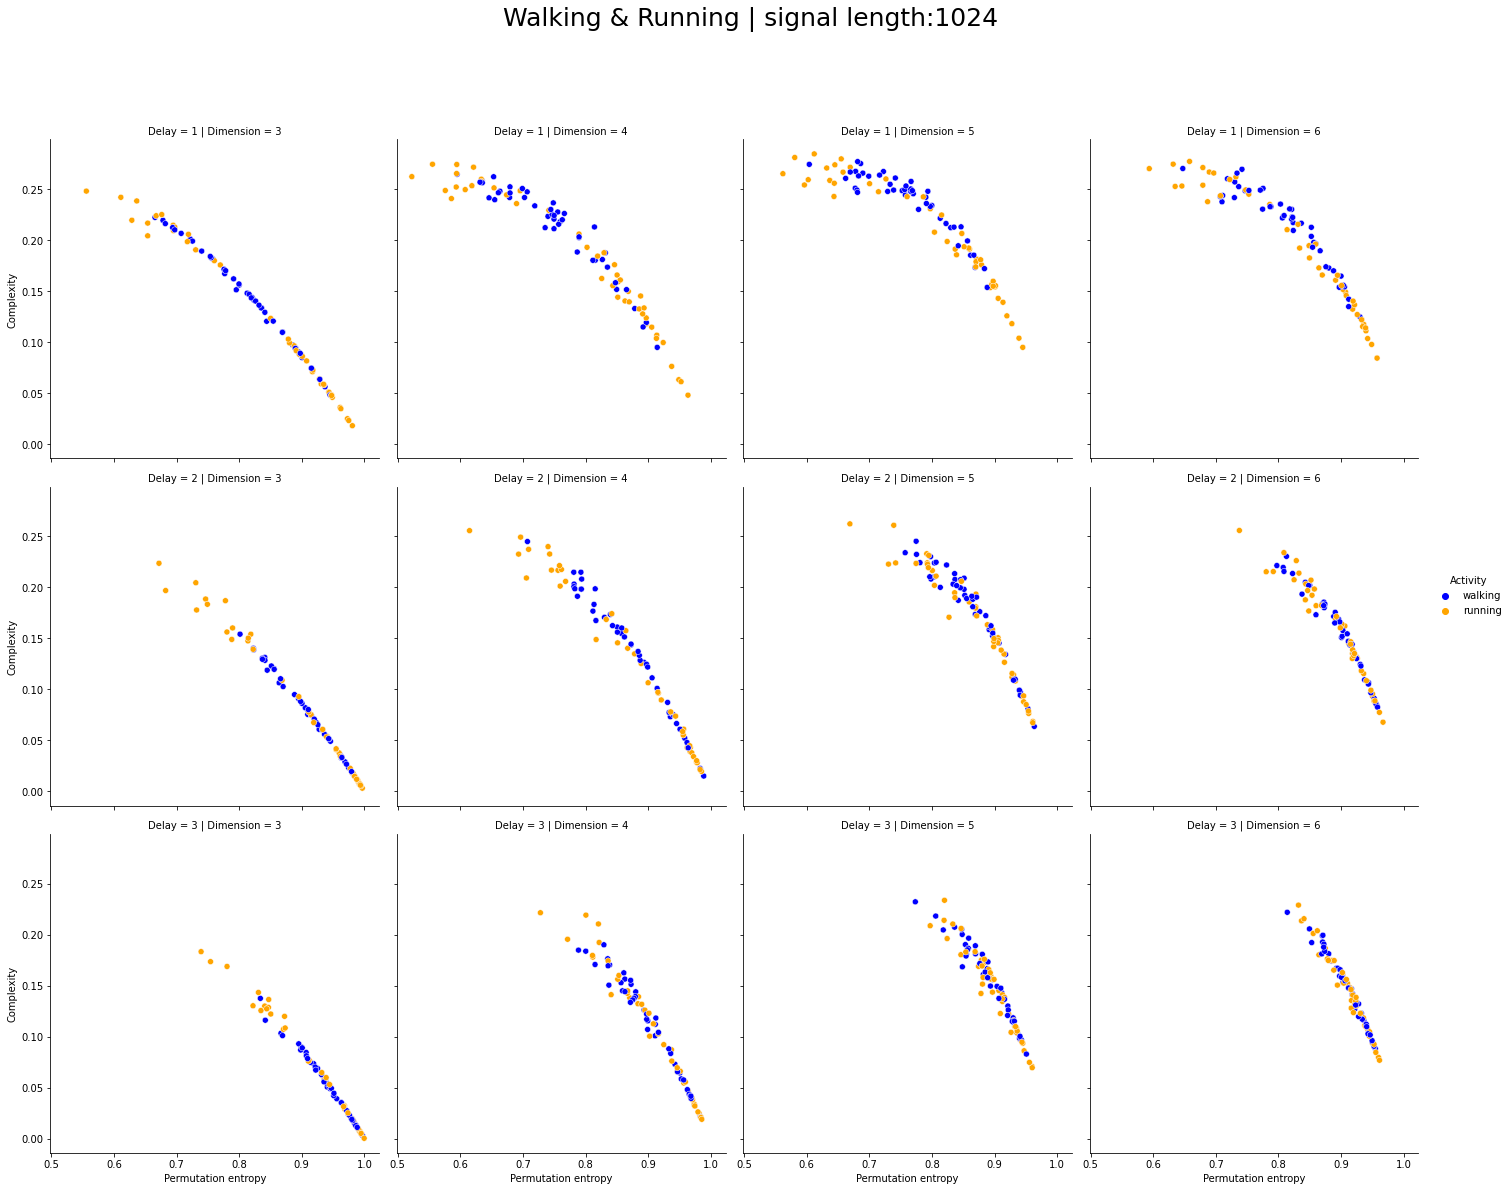

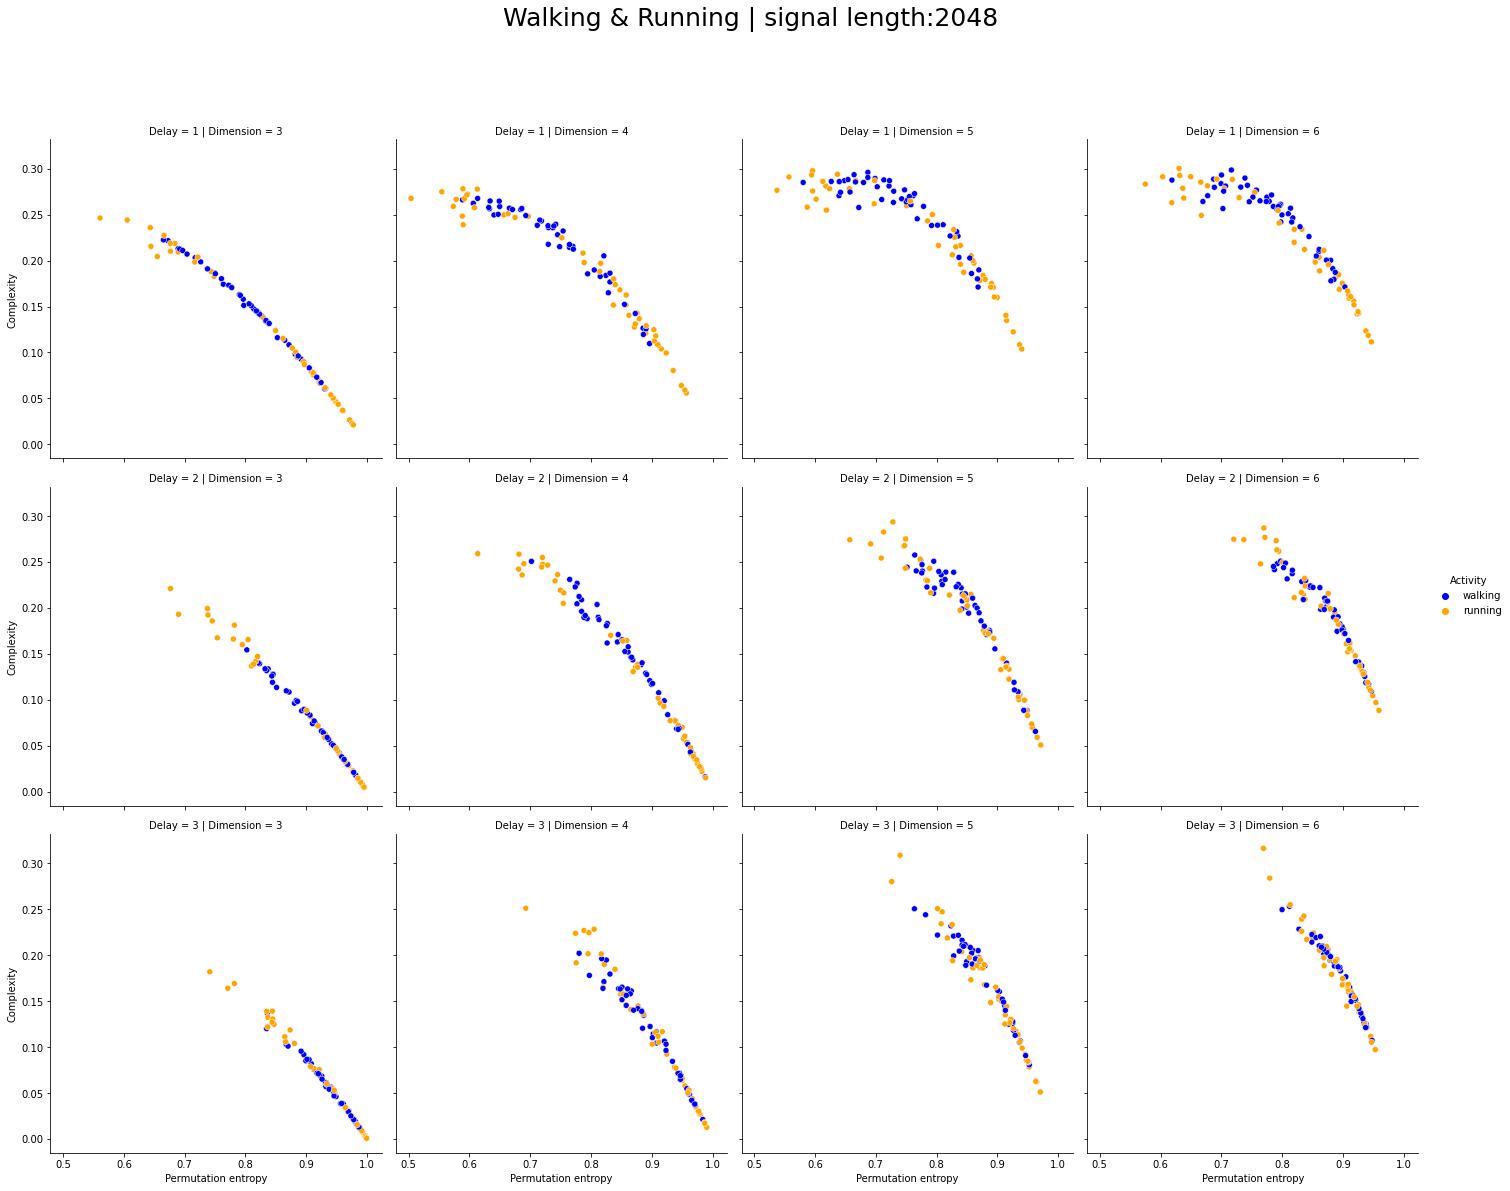

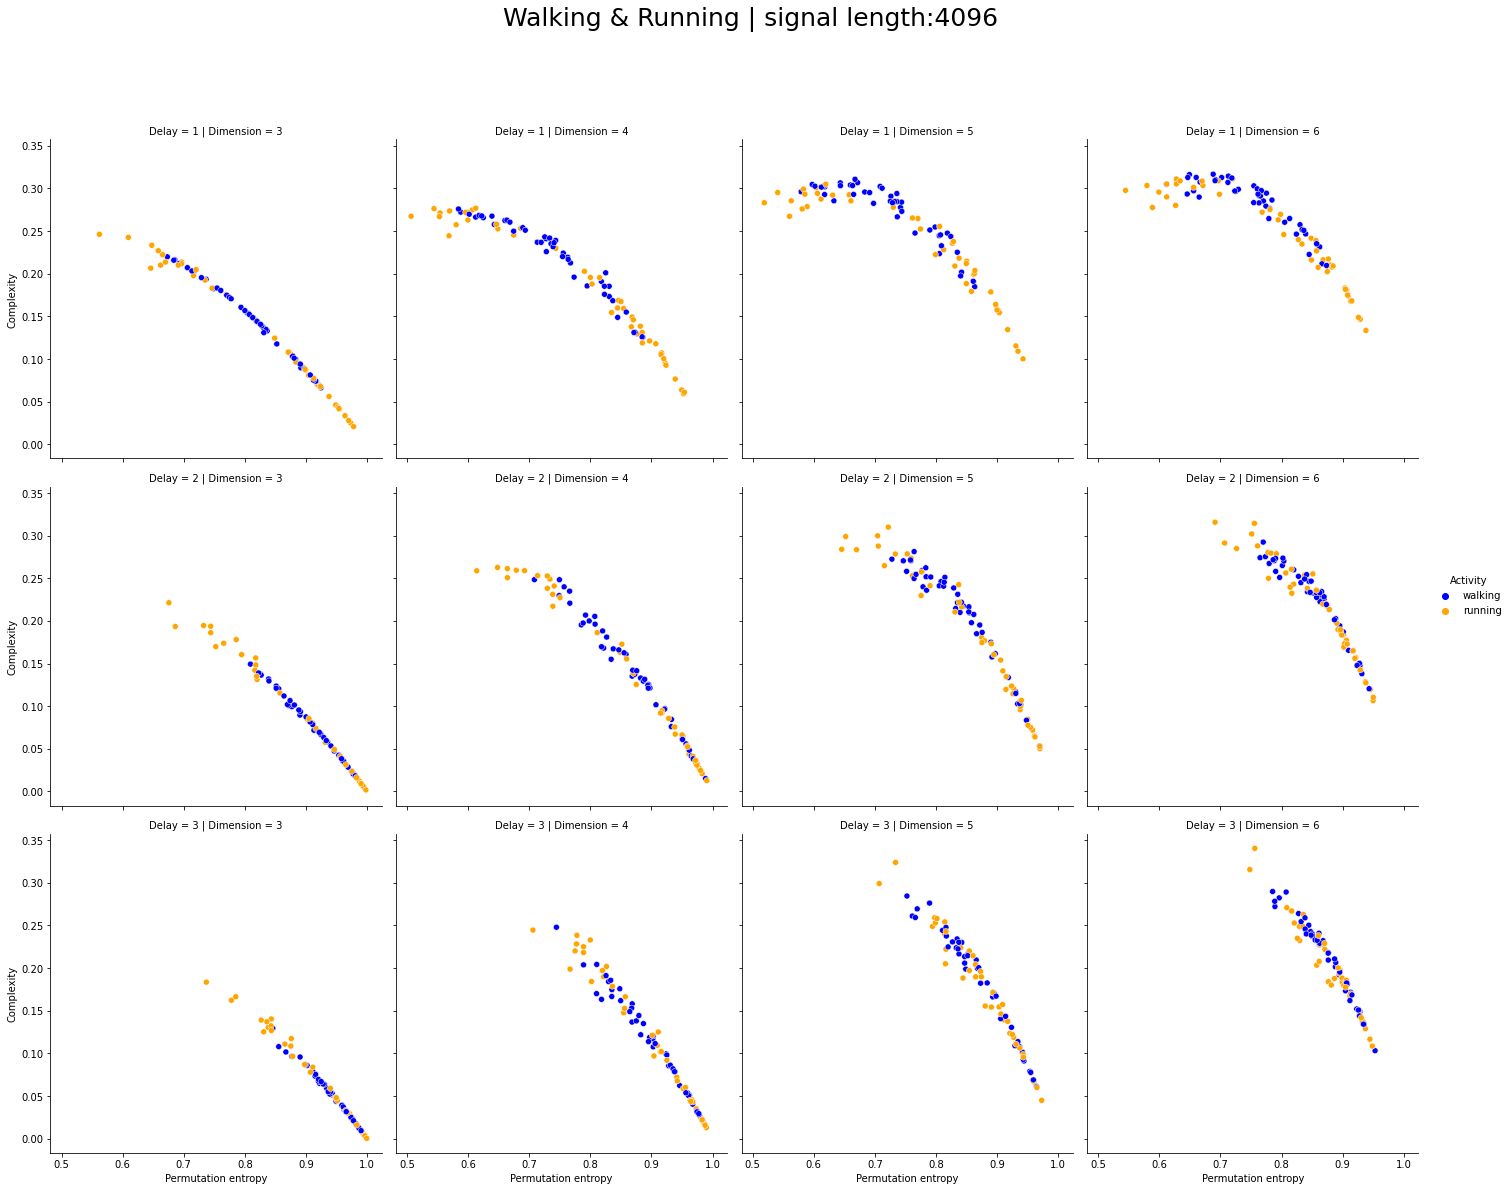

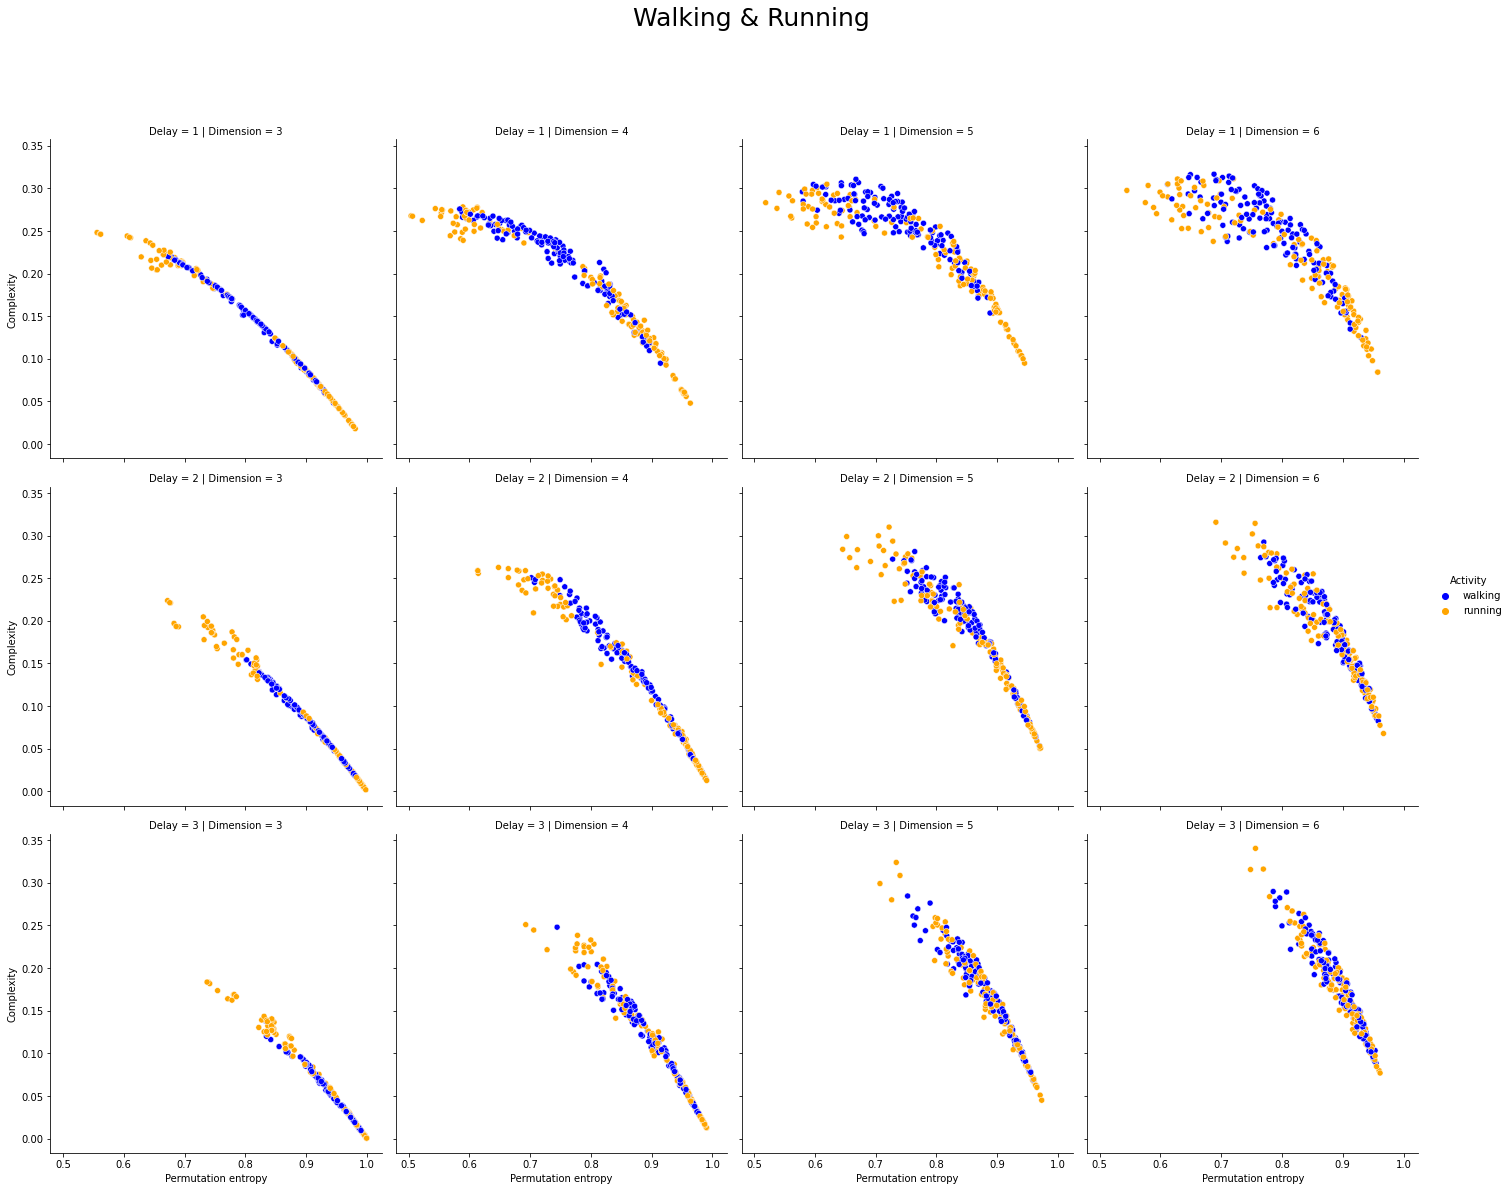

In [13]:
# Subset of walking and running data
table_walk = table[(table['Activity'] == 'walking') | (table['Activity'] == 'running')]


# Scatter plots for each dimension, delay, and signal length
for sl in [1024, 2048, 4096]:
    # Subset of signal length data 
    to_plot = table_walk[table_walk['Signal length'] == sl]
    
    # Create plot
    sns.relplot(data=to_plot, x='Permutation entropy', y='Complexity', 
                col='Dimension', row='Delay', 
                hue='Activity', palette=['blue', 'orange']
               ).fig.suptitle('Walking & Running | signal length:{sl}'.format(sl=sl), y=1.1, fontsize=25)
    
    # Save plot
    plt.savefig('walking_running_{sl}.png'.format(sl=sl))
    

# Complete plot with all signal lengths
complete_plot = sns.relplot(data=table_walk, x='Permutation entropy', y='Complexity', 
                            col='Dimension', row='Delay', 
                            hue='Activity', palette=['blue', 'orange']
                           ).fig.suptitle('Walking & Running', y=1.1, fontsize=25)

# Save figure
plt.savefig("walking_running.png")

#### Deciding optimum dimension and delay from scatter plots
The feature values that seem to offer the best seperatation between walking and running are as follows, with the best sepration overall in bold:

   • **Signal length: 1024, delay: 2, dimensions: 3** <br>
   • Signal length: 2048, delay: 3, dimensions: 3 <br>
   • Signal length: 4096, delay: 3, dimensions: 3


# Task 4 - Climbing Up and Climbing Down Scatter Plots
Here I create complexity vs. permutation entropy scatter plots for the climbing up and climbing down data. I seperate the plots by signal length to help determine the optimal parameters for best separation between climbing up and climbing down. Again, the combination of all signal lengths is saved as a separate plot.

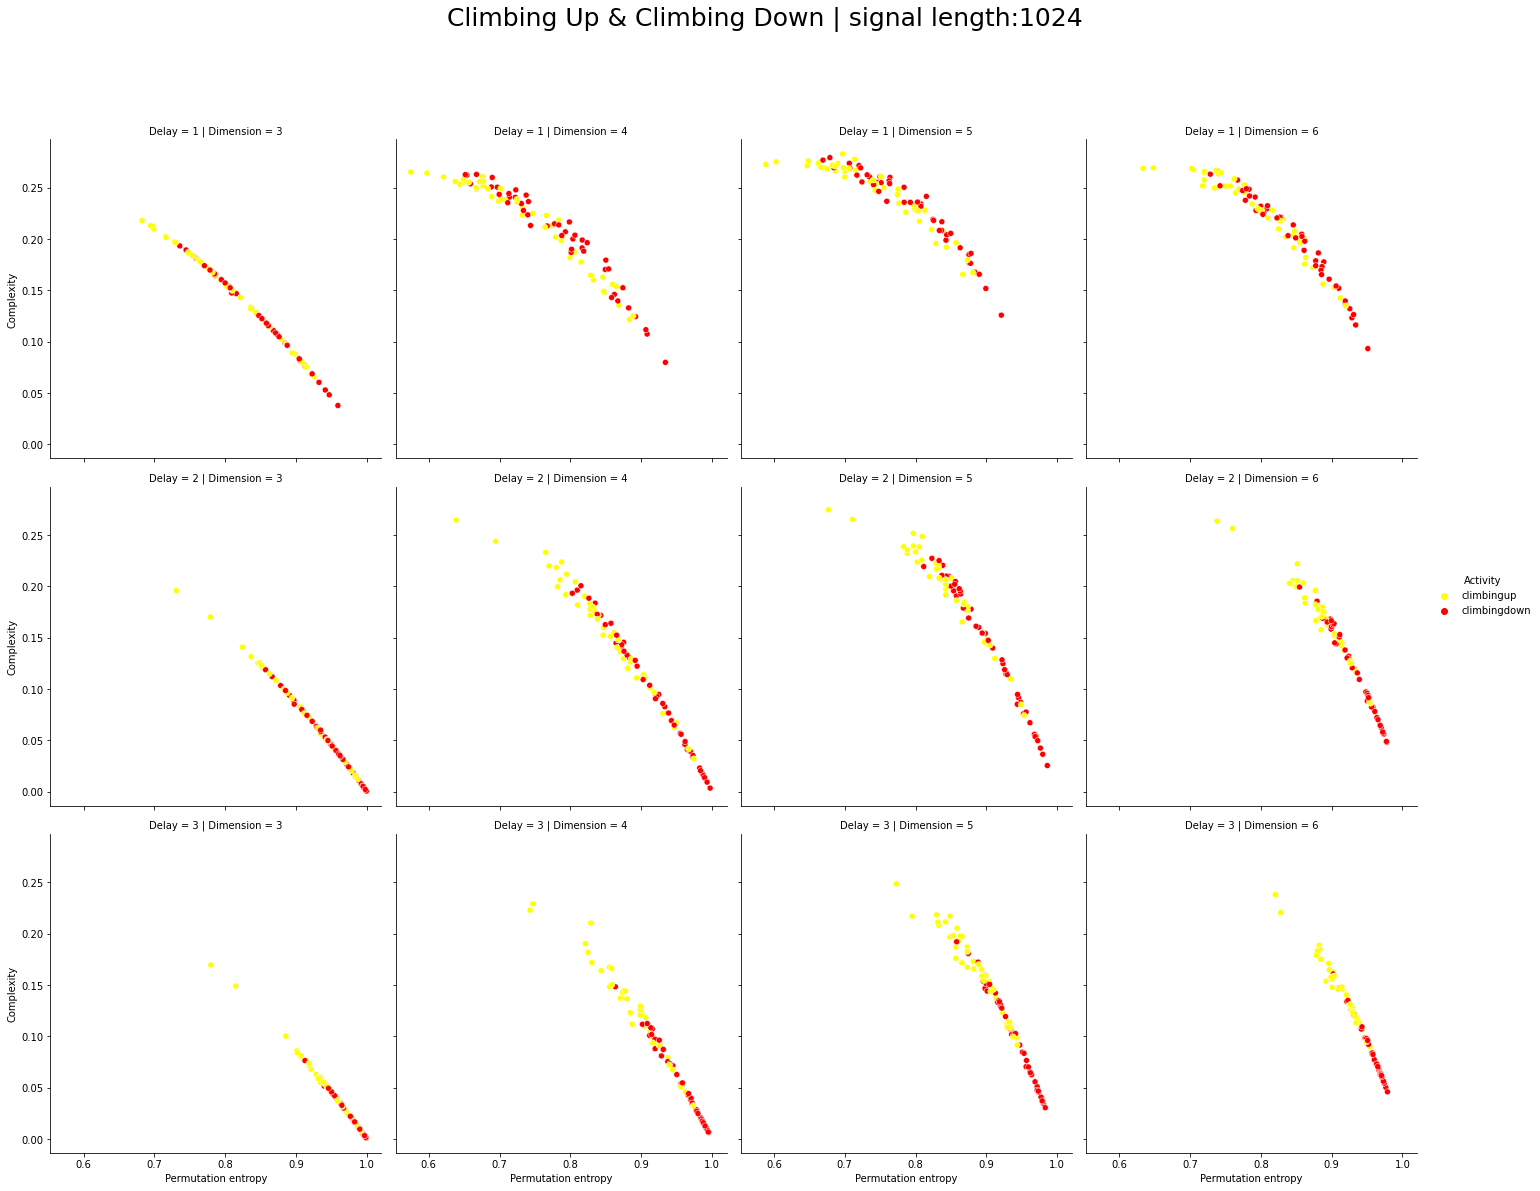

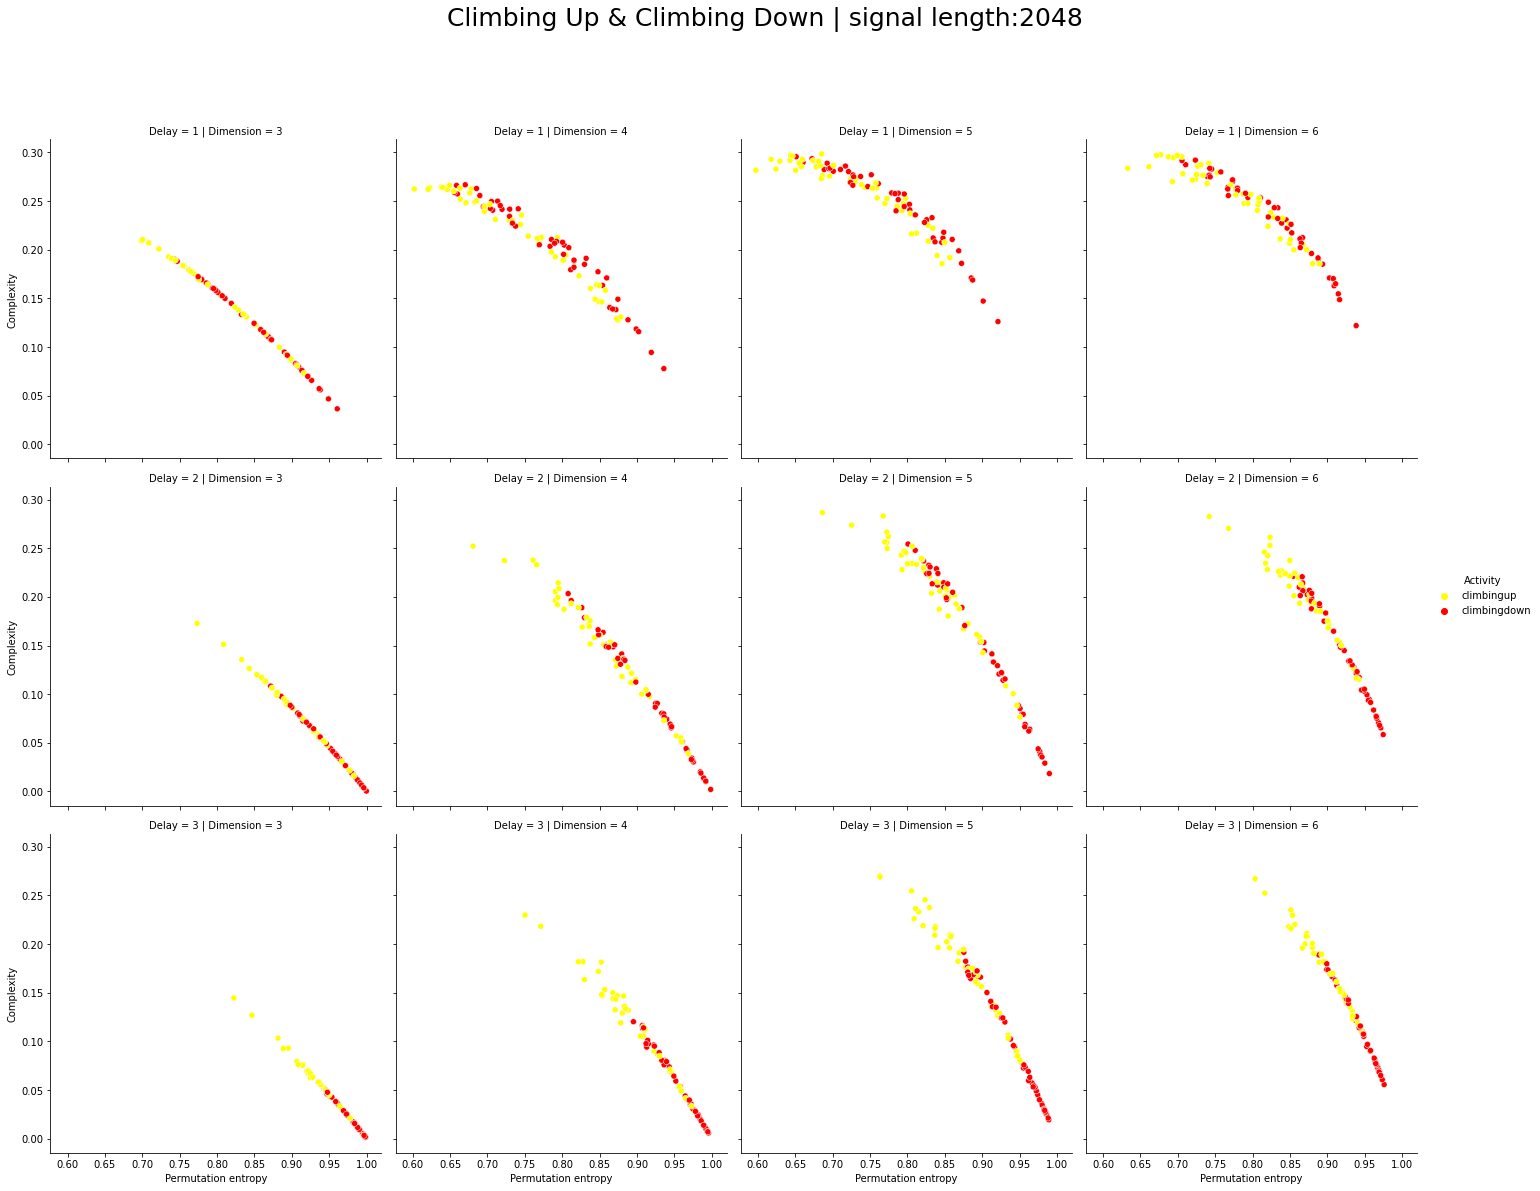

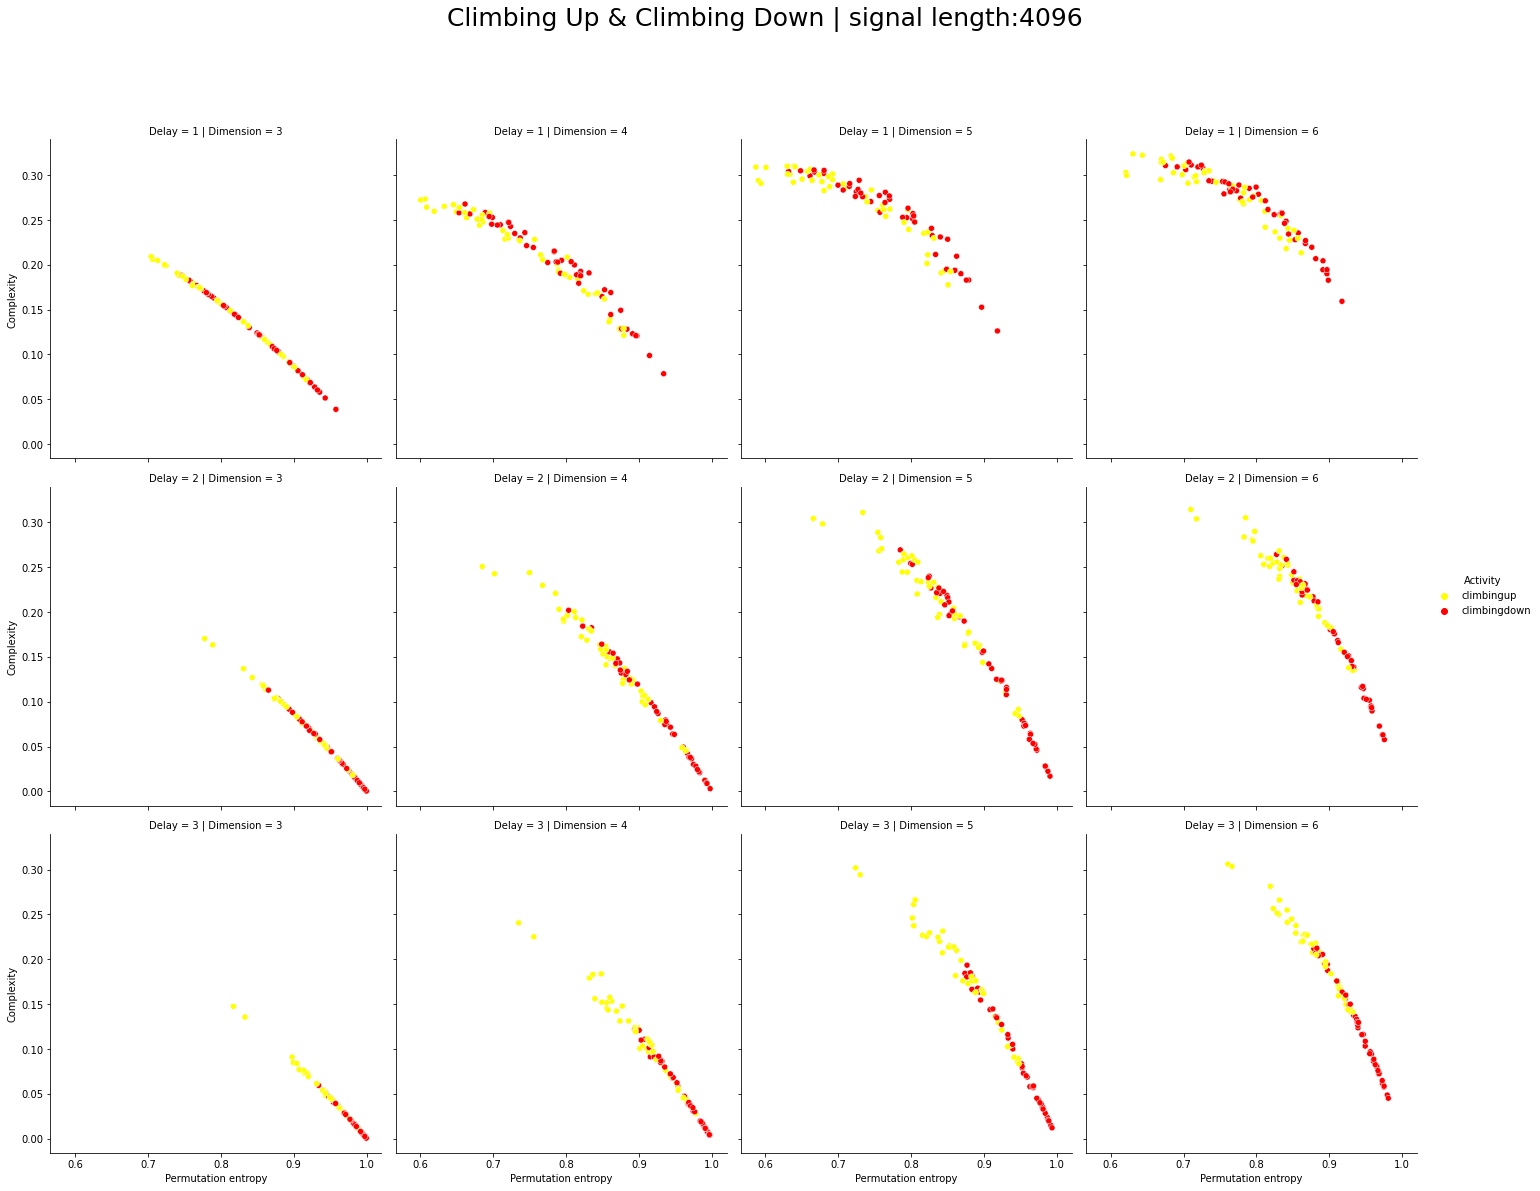

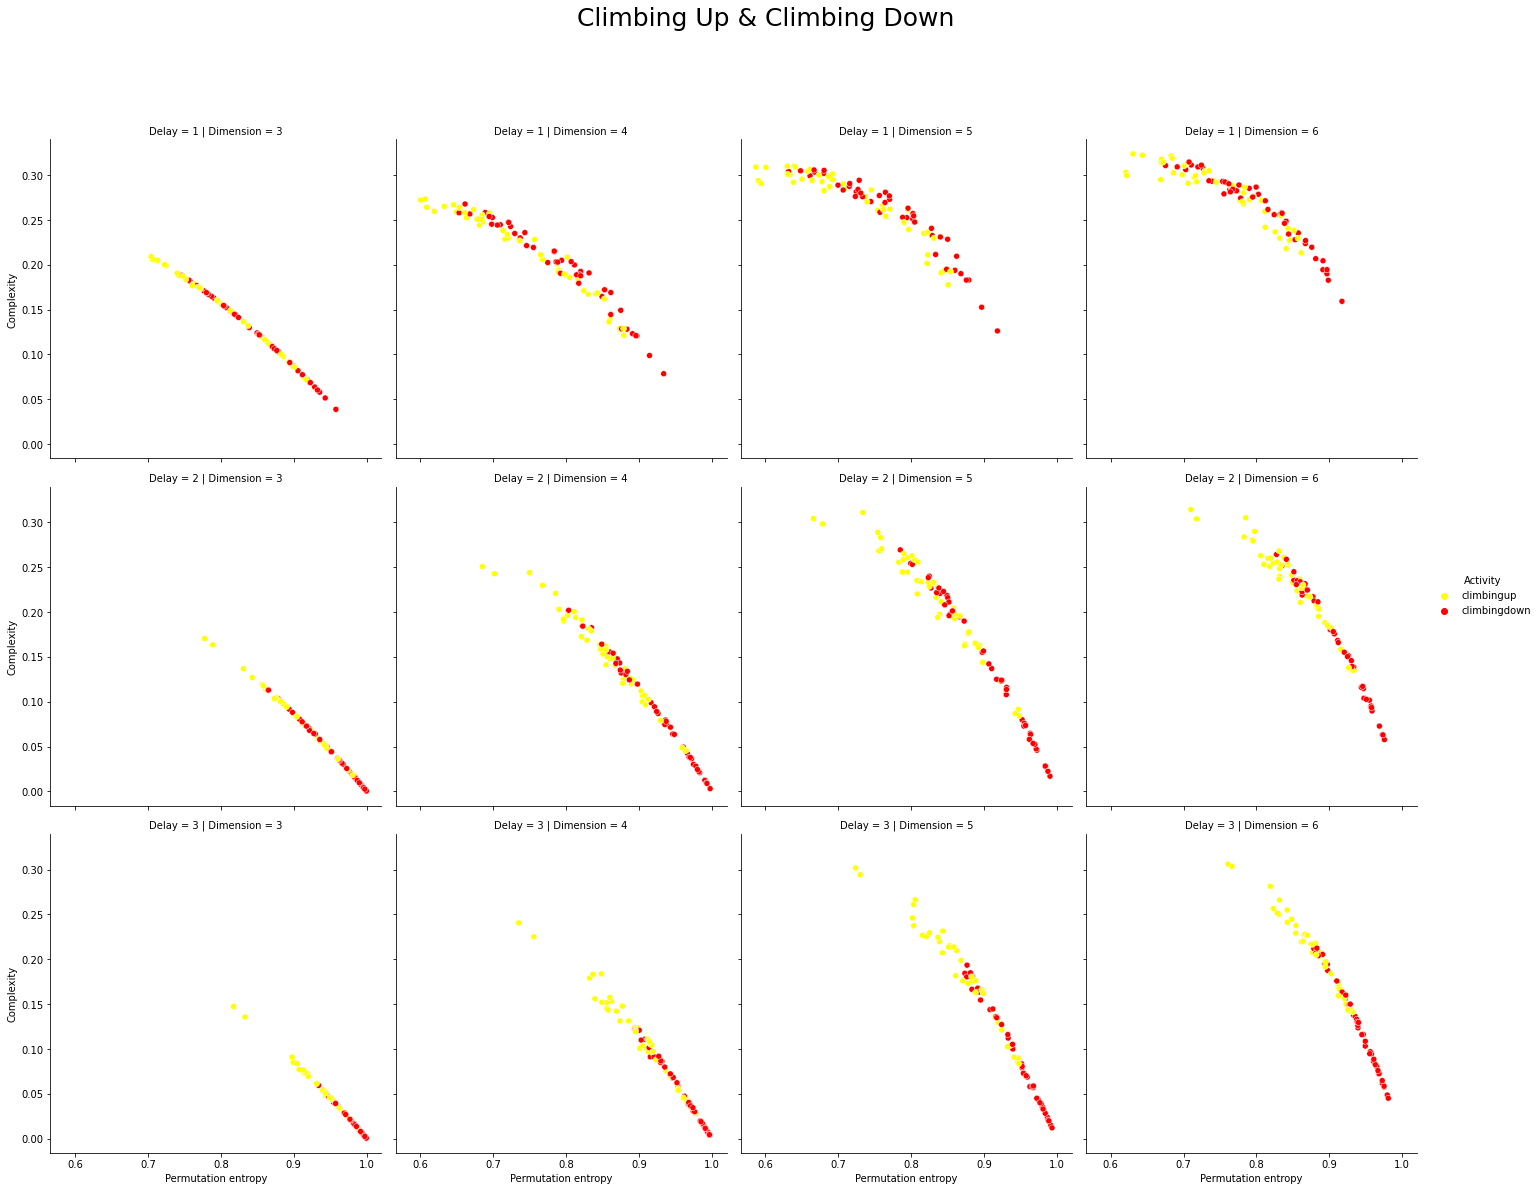

In [14]:
# Subset of walking and running data
table_climb = table[(table['Activity'] == 'climbingup') | (table['Activity'] == 'climbingdown')]

# Scatter plots for each dimension, delay, and signal length
for sl in [1024, 2048, 4096]:
    # Subset of signal length data 
    to_plot = table_climb[table_climb['Signal length'] == sl]
    
    # Create plot
    sns.relplot(data=to_plot, x='Permutation entropy', y='Complexity', 
                col='Dimension', row='Delay', 
                hue='Activity', palette=['yellow', 'red']
               ).fig.suptitle('Climbing Up & Climbing Down | signal length:{sl}'.format(sl=sl), y=1.1, fontsize=25)
    
    # Save plot
    plt.savefig('climbing_{sl}.png'.format(sl=sl))


# Complete plot with all signal lengths
complete_plot = sns.relplot(data=to_plot, x='Permutation entropy', y='Complexity', 
                            col='Dimension', row='Delay', 
                            hue='Activity', palette=['yellow', 'red']
                           ).fig.suptitle('Climbing Up & Climbing Down', y=1.1, fontsize=25)

# Save figure
plt.savefig("climbing.png")

#### Deciding optimum dimension and delay from scatter plots
The feature values that seem to offer the best seperatation between climbing up and climbing down are as follows, with the best sepration overall in bold:

   • Signal length: 1024, delay: 3, dimensions: 6 <br>
   • Signal length: 2048, delay: 3, dimensions: 4 <br>
   • **Signal length: 4096, delay: 3, dimensions: 4**

---

# Versions

In [15]:
# Jupyter
!jupyter --version

jupyter core     : 4.6.3
jupyter-notebook : 6.0.3
qtconsole        : not installed
ipython          : 7.14.0
ipykernel        : 5.2.1
jupyter client   : 6.1.3
jupyter lab      : 2.1.1
nbconvert        : 5.6.1
ipywidgets       : 7.5.1
nbformat         : 5.0.6
traitlets        : 4.3.3


In [16]:
# Python
from platform import python_version
print(python_version())

3.7.6
